# Introduzione
In questo progetto analizzeremo un dataset bancario per predire se un cliente sottoscriverà un deposito a termine (target binario: "yes" o "no").
Verranno applicate tecniche di Machine Learning con attenzione a bilanciamento, selezione delle feature e valutazione dei modelli.

In [25]:
# Import delle librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, recall_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Caricamento del dataset e Analisi esplorativa dei dati (EDA): 
Il dataset è stato inizialmente esplorato per comprenderne la struttura, la distribuzione delle variabili e l'eventuale presenza di valori anomali o mancanti. È stata effettuata un'analisi della distribuzione della variabile target, della correlazione tra le variabili numeriche e della composizione delle variabili categoriche.

Dimensioni del dataset: (45211, 17)

Prime 5 righe:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no



Informazioni sul dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


None

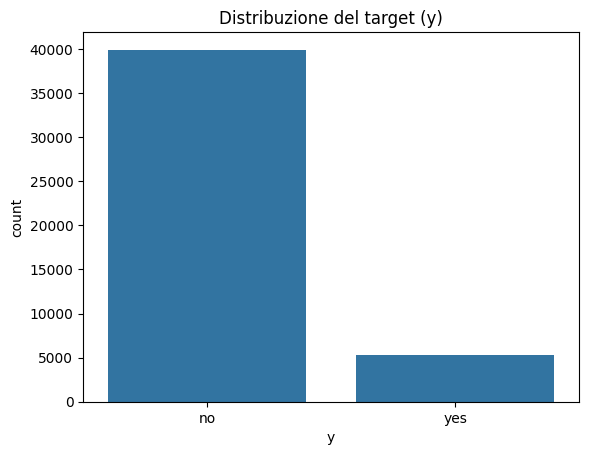

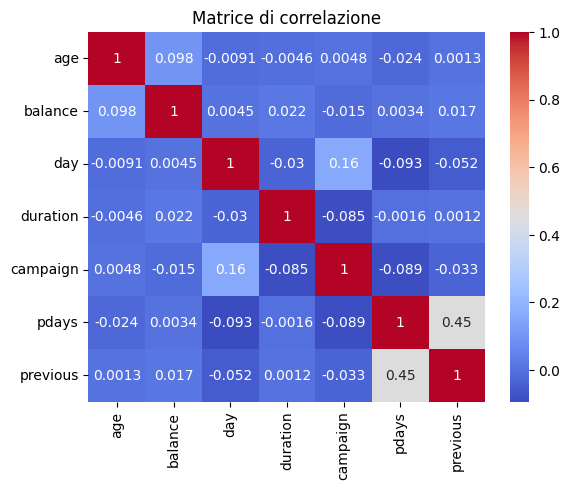

Valori nulli:
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Valori unici per ogni colonna categorica:
job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital: ['married' 'single' 'divorced']
education: ['tertiary' 'secondary' 'unknown' 'primary']
default: ['no' 'yes']
housing: ['yes' 'no']
loan: ['no' 'yes']
contact: ['unknown' 'cellular' 'telephone']
month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome: ['unknown' 'failure' 'other' 'success']
y: ['no' 'yes']


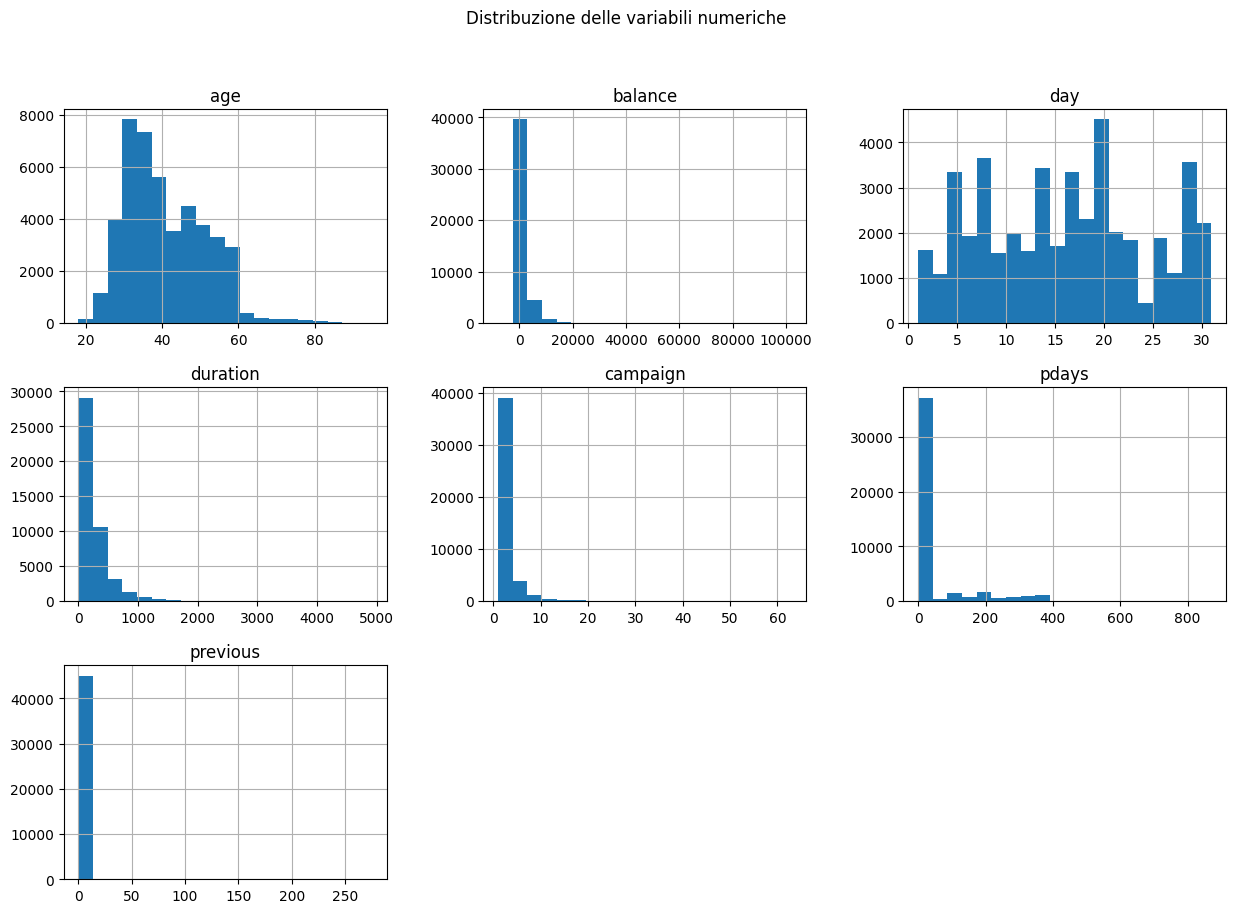

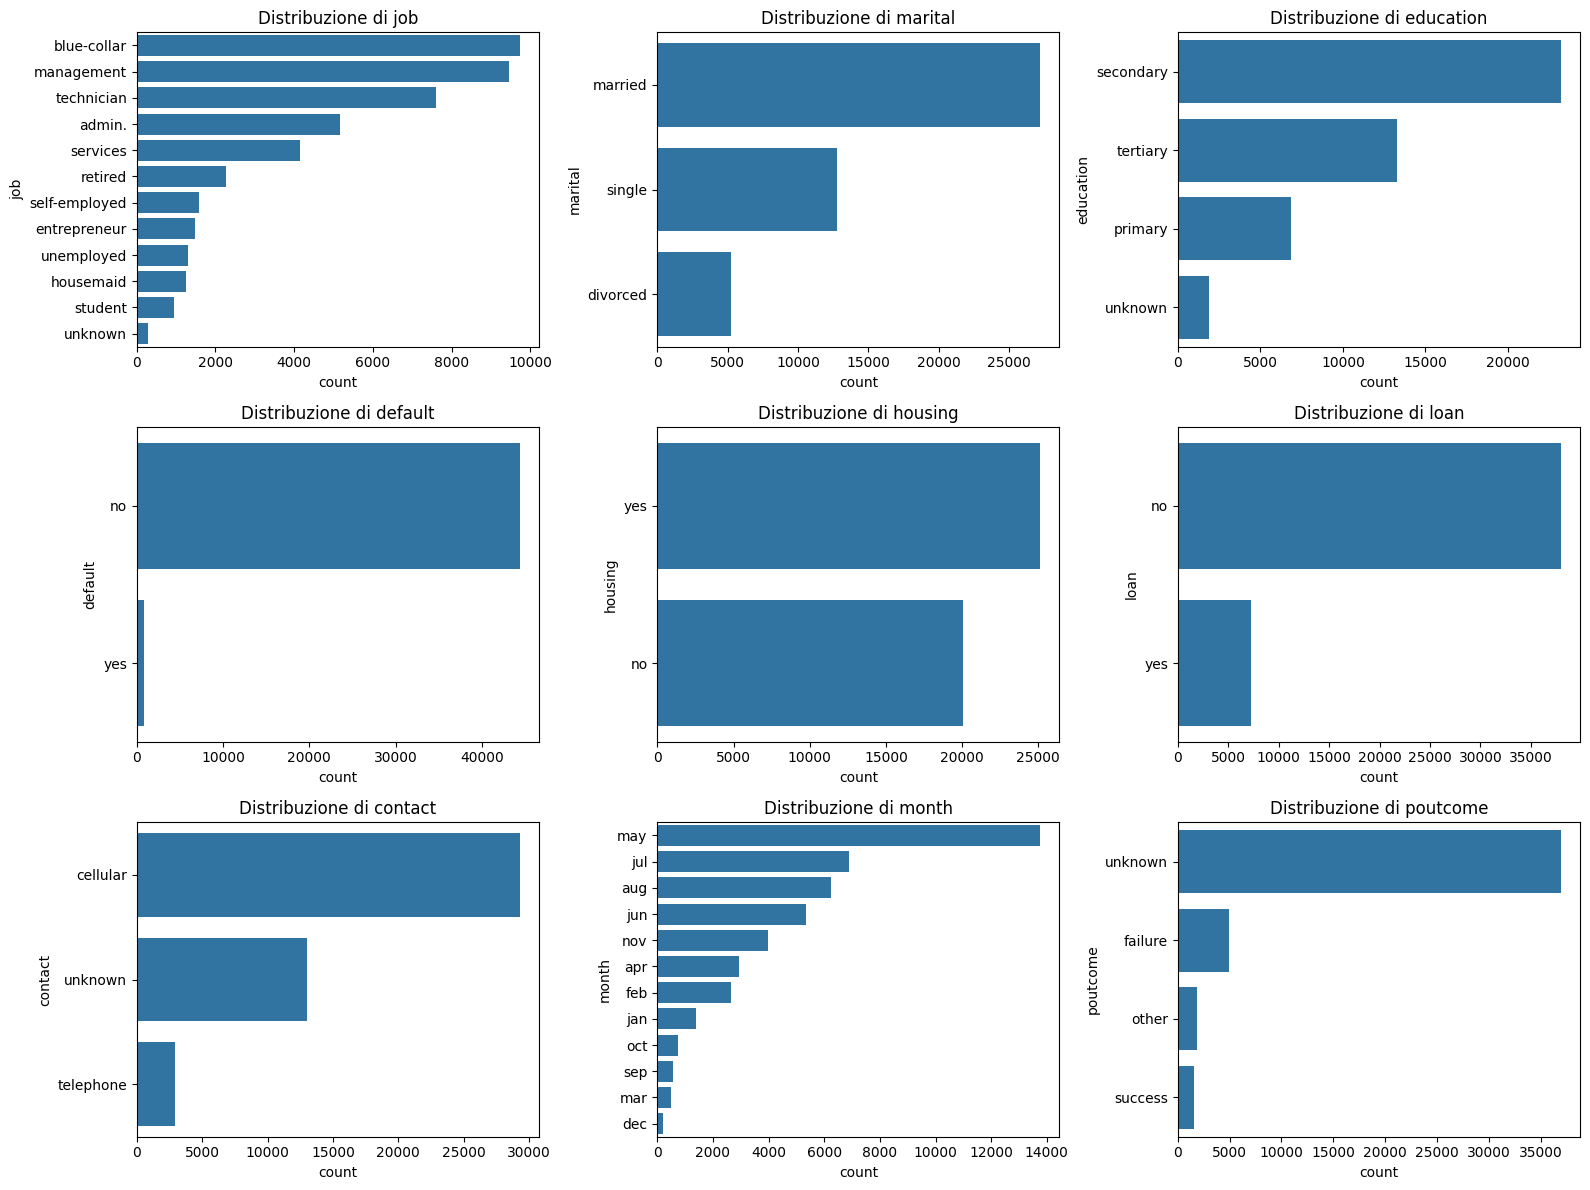

In [26]:
# Caricamento del dataset
df = pd.read_csv('bank.csv', sep=';')  

# Analisi esplorativa dei dati
print("Dimensioni del dataset:", df.shape)
print("\nPrime 5 righe:")
display(df.head())

print("\nInformazioni sul dataset:")
display(df.info())

# Distribuzione della variabile target
sns.countplot(data=df, x="y")
plt.title("Distribuzione del target (y)")
plt.show()

# Correlazioni numeriche
numeriche = df.select_dtypes(include=["int64", "float64"])
sns.heatmap(numeriche.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice di correlazione")
plt.show()

# Valori nulli (Assenti)
print("Valori nulli:\n", df.isnull().sum())

print("\nValori unici per ogni colonna categorica:")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].unique()}")

# Distribuzione delle variabili numeriche
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
df[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribuzione delle variabili numeriche')
plt.show()

# Distribuzione delle variabili categoriche
categorical_cols = ["job","marital","education","default","housing","loan","contact","month","poutcome"]
plt.figure(figsize=(16, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribuzione di {col}")
plt.tight_layout()
plt.show()


# Preprocessing dei dati:
Le operazioni di preprocessing hanno incluso:
* La sostituzione dei valori "unknown" con NaN, successivamente imputati utilizzando la moda.
* L'eliminazione della variabile poutcome, caratterizzata da un'alta percentuale di valori mancanti.
* L'aggiunta della categoria "no_contact" per rappresentare i valori mancanti nella variabile contact.
* La conversione della variabile target in formato binario numerico (1 = "yes", 0 = "no").
* L'applicazione dell'one-hot encoding per le variabili categoriche.

In [27]:
# Sostituiamo "unknown" con NaN 
df.replace('unknown', np.NaN, inplace=True)

# Analisi dei valori mancanti
print("\nValori mancanti prima del trattamento:")
print(df.isnull().sum())

# Imputazione dei valori mancanti con la moda
for col in ['education', 'job']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Rimozione della feature 'poutcome'
df.drop("poutcome", axis=1, inplace=True)

# Gestione dei missing values nella feature 'contact'
df['contact'].fillna('no_contact', inplace=True)

# Conversione della variabile target 'y' in formato numerico binario
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Verifica finale dei missing values
print("\n\nValori mancanti dopo il trattamento:")
print(df.isnull().sum())

# Encoding delle feature categoriche
df_encoded = pd.get_dummies(df.drop('y', axis=1), drop_first=True)

# Split X, y
X = df.drop("y", axis=1)
y = df["y"]

# Verifica del risultato
print("\nDataset dopo la codifica:")
display(df.head())



Valori mancanti prima del trattamento:
age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64


Valori mancanti dopo il trattamento:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
y            0
dtype: int64

Dataset dopo la codifica:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,no_contact,5,may,261,1,-1,0,0
1,44,technician,single,secondary,no,29,yes,no,no_contact,5,may,151,1,-1,0,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,no_contact,5,may,76,1,-1,0,0
3,47,blue-collar,married,secondary,no,1506,yes,no,no_contact,5,may,92,1,-1,0,0
4,33,blue-collar,single,secondary,no,1,no,no,no_contact,5,may,198,1,-1,0,0


# Feature selection
È stata utilizzata la tecnica SelectKBest con punteggio ANOVA (f_classif) per selezionare le 10 variabili più rilevanti per la predizione della variabile target.

In [28]:
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(df_encoded, y)
selected_features = df_encoded.columns[selector.get_support()].tolist()

print("Feature selezionate:", selected_features)

Feature selezionate: ['duration', 'pdays', 'previous', 'job_retired', 'housing_yes', 'contact_no_contact', 'month_mar', 'month_may', 'month_oct', 'month_sep']


# Suddivisione in train e test
Il dataset è stato suddiviso in un set di addestramento (80%) e uno di test (20%) utilizzando uno split stratificato per mantenere la proporzione delle classi.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

print(f"Dimensioni Train: {X_train.shape}, Test: {X_test.shape}")

Dimensioni Train: (36168, 10), Test: (9043, 10)


# Modellazione e valutazione
La variabile target è sbilanciata, quindi ho deciso di applicare SMOTE (Synthetic Minority Oversampling Technique) per bilanciare il training set. Sono stati addestrati quattro modelli:
* Random Forest
* Gradient Boosting
* Regressione Logistica
* Naive Bayes

Per ciascun modello sono state calcolate le metriche: Accuracy, F1-score, ROC AUC, classification report e matrice di confusione.


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      7985
           1       0.33      0.62      0.43      1058

    accuracy                           0.81      9043
   macro avg       0.64      0.72      0.66      9043
weighted avg       0.87      0.81      0.83      9043



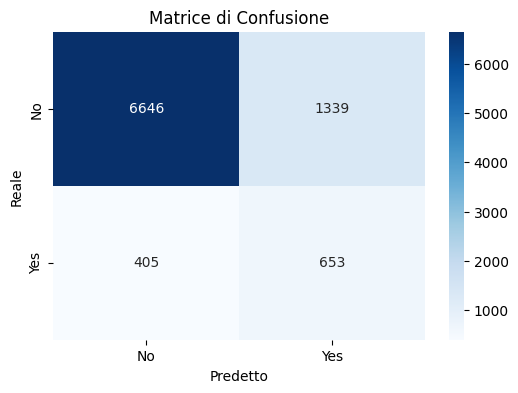


--- Gradient Boosting ---
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      7985
           1       0.34      0.80      0.48      1058

    accuracy                           0.79      9043
   macro avg       0.65      0.80      0.67      9043
weighted avg       0.89      0.79      0.83      9043



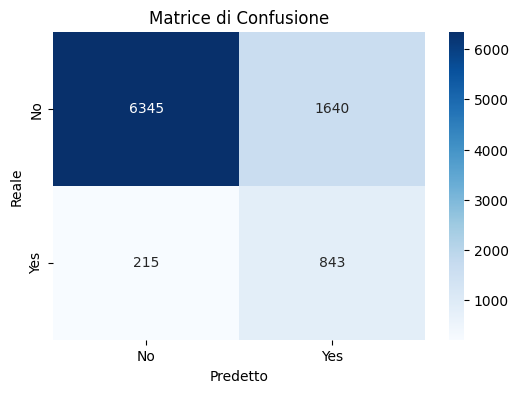


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      7985
           1       0.34      0.72      0.46      1058

    accuracy                           0.80      9043
   macro avg       0.65      0.77      0.67      9043
weighted avg       0.88      0.80      0.83      9043



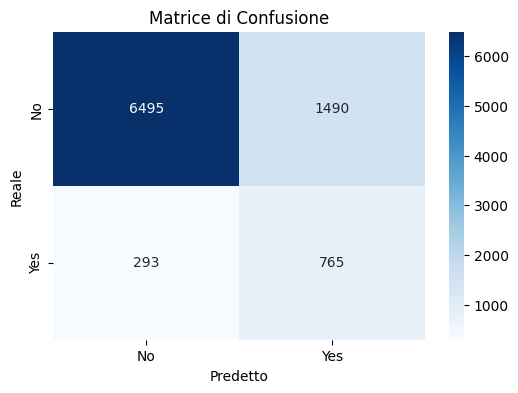


--- Naive Bayes ---
              precision    recall  f1-score   support

           0       0.94      0.64      0.77      7985
           1       0.21      0.70      0.32      1058

    accuracy                           0.65      9043
   macro avg       0.57      0.67      0.54      9043
weighted avg       0.86      0.65      0.71      9043



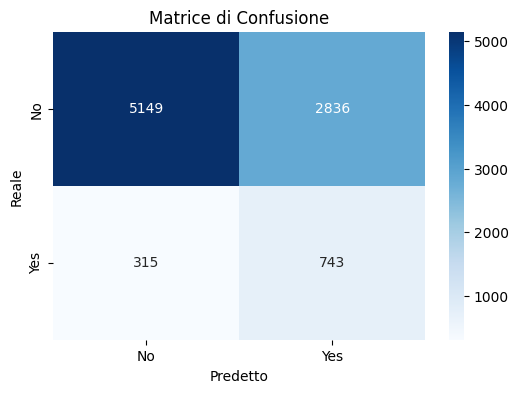

Distribuzione originale: Counter({0: 31937, 1: 4231})
Distribuzione dopo SMOTE: Counter({0: 31937, 1: 31937})


In [30]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB() 
}
results = {}

for name, model in models.items():
    pipeline = ImbPipeline(steps=[
        ("smote", SMOTE(random_state=42)),
        ("clf", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1]
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    }
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    
    # Grafico per il Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title("Matrice di Confusione")
    plt.xlabel("Predetto")
    plt.ylabel("Reale")
    plt.show()

# Estraggo i dati trasformati da SMOTE (dalla pipeline)
smote_step = pipeline.named_steps['smote']
X_resampled, y_resampled = smote_step.fit_resample(X_train, y_train)

print("Distribuzione originale:", Counter(y_train))
print("Distribuzione dopo SMOTE:", Counter(y_resampled))


# Confronto dei modelli
Le prestazioni dei modelli sono state confrontate graficamente e tabellarmente. Il modello con il miglior punteggio ROC AUC è stato identificato come il più efficace nel distinguere le classi.


Riepilogo prestazioni:
                      Accuracy        F1   ROC AUC
Gradient Boosting    0.794869  0.476137  0.875939
Logistic Regression  0.802831  0.461817  0.845154
Random Forest        0.807144  0.428197  0.824966
Naive Bayes          0.651554  0.320466  0.773157


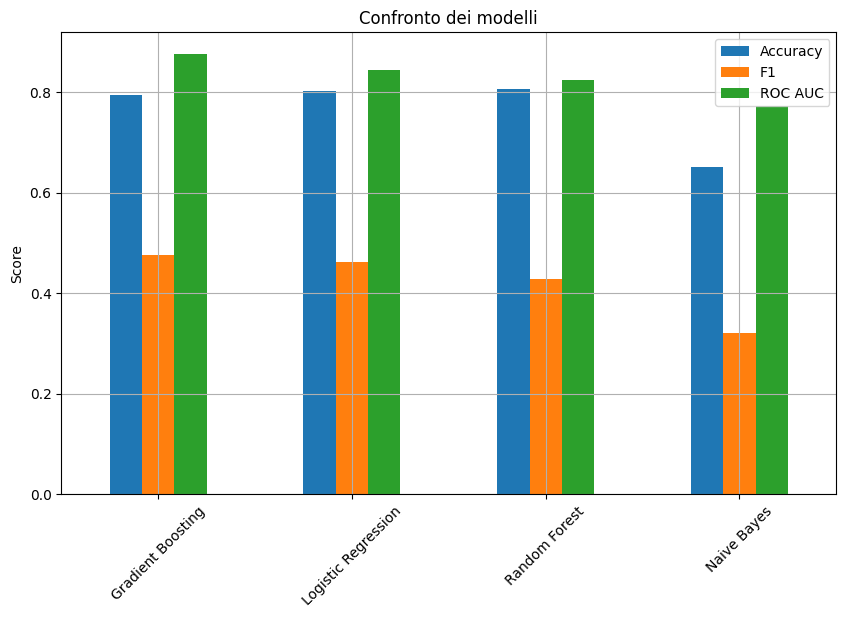

In [31]:
results_df = pd.DataFrame(results).T.sort_values("ROC AUC", ascending=False)
print("\nRiepilogo prestazioni:\n", results_df)

results_df.plot(kind="bar", figsize=(10,6))
plt.title("Confronto dei modelli")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Conclusioni
Il modello con le migliori prestazioni, secondo la metrica ROC AUC, è risultato essere il **Gradient Boosting**.
Il modello Naive Bayes, pur essendo molto veloce, ha ottenuto prestazioni inferiori, come previsto, a causa delle sue ipotesi semplificative.  L’approccio implementato ha dimostrato efficacia nel trattare problemi di classificazione sbilanciata, mantenendo una buona interpretabilità e robustezza.